In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

# Loading and inspecting data

In [59]:
os.getcwd()
labels = pd.read_csv('aerialcactus_data/train.csv')
submission = pd.read_csv('aerialcactus_data/sample_submission.csv')

train_path = r'aerialcactus_data/train_img/'
test_path = r'aerialcactus_data/test_img/'

labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [60]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [61]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

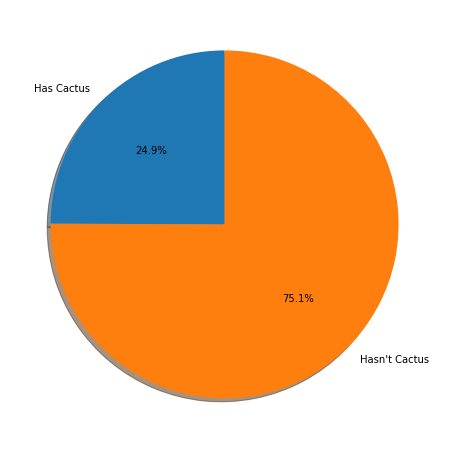

In [62]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize= (8,8))
plt.pie(labels.groupby('has_cactus').size(), labels= label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

# Image Pre-processing

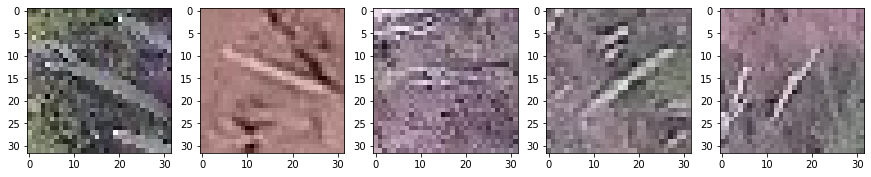

In [63]:
import matplotlib.image as img

# images with cactus
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

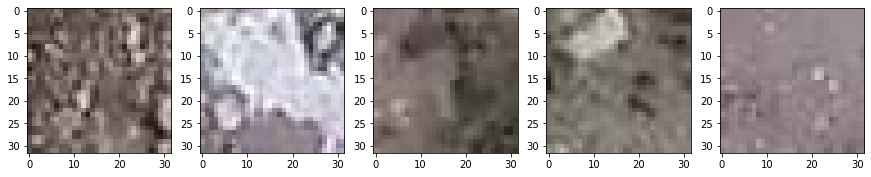

In [65]:
# images without cactus
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [66]:
# standardize images defined by meand and stdv
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [67]:
# define dataset
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# Normalization

In [77]:
means = 0
std = 1
train_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(means,std)])
test_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(means,std)])
valid_transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(means,std)])

# Splitting the Dataset

In [78]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [79]:
# hyperparameters
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [80]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [81]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [82]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

training images
torch.Size([3, 32, 32])


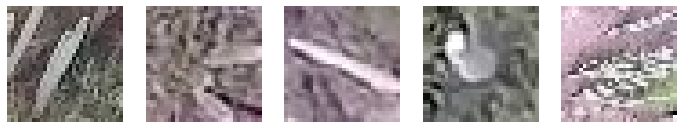

In [83]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

# Make CNN

In [86]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [87]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


# Optimization

In [88]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [89]:
%%time
# keeping track of losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward-pass
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward-pass
        loss.backward()
        # parameter-update
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)
        
    # validate model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.276179 	Validation Loss: 0.146687
Epoch: 2 	Training Loss: 0.155458 	Validation Loss: 0.111793
Epoch: 3 	Training Loss: 0.138049 	Validation Loss: 0.104902
Epoch: 4 	Training Loss: 0.125625 	Validation Loss: 0.106803
Epoch: 5 	Training Loss: 0.113684 	Validation Loss: 0.089337
Epoch: 6 	Training Loss: 0.107123 	Validation Loss: 0.066934
Epoch: 7 	Training Loss: 0.098624 	Validation Loss: 0.067743
Epoch: 8 	Training Loss: 0.103806 	Validation Loss: 0.077461
Epoch: 9 	Training Loss: 0.090208 	Validation Loss: 0.074951
Epoch: 10 	Training Loss: 0.084618 	Validation Loss: 0.072293
Epoch: 11 	Training Loss: 0.085731 	Validation Loss: 0.059677
Epoch: 12 	Training Loss: 0.083632 	Validation Loss: 0.057648
Epoch: 13 	Training Loss: 0.073811 	Validation Loss: 0.053911
Epoch: 14 	Training Loss: 0.070509 	Validation Loss: 0.073315
Epoch: 15 	Training Loss: 0.072474 	Validation Loss: 0.066564
Epoch: 16 	Training Loss: 0.066842 	Validation Loss: 0.066792
Epoch: 17 	Traini

In [90]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 97.51428571428572 %


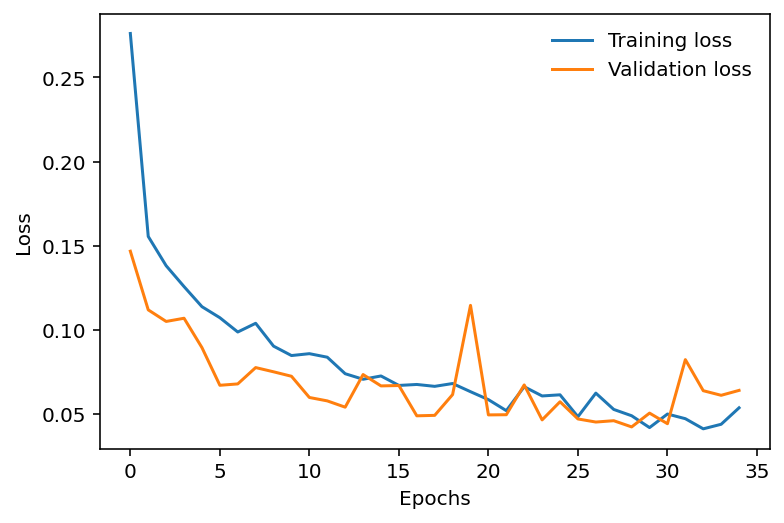

In [92]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()